In [ ]:
# Step-1: Mount Google Drive
# ---------------------------
# Mount Google Drive to access the dataset and save results.
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Step-2: Install Dependencies
# -----------------------------
# Install necessary packages from GitHub and PyPI.
!pip install git+https://github.com/openai/whisper.git
!pip install language-tool-python
!pip install textstat
!pip install xgboost


  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-e9x29j1h
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-e9x29j1h
  Resolved https://github.com/openai/whisper.git to commit 517a43ecd132a2089d85f4ebc044728a71d49f6e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━

In [ ]:
# Step-3: Load Data and Define Paths
# ----------------------------------
# Load the training and test CSV files and set the audio directories.
import pandas as pd
import os

# Load data from Google Drive
train_df = pd.read_csv('/content/drive/MyDrive/dataset/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/dataset/test.csv')

# Define directories for audio files
train_audio_dir = '/content/drive/MyDrive/dataset/audios_train'
test_audio_dir = '/content/drive/MyDrive/dataset/audios_test'


In [ ]:
# Step-4: Audio Transcription with Whisper
# -----------------------------------------
# Transcribe audio files using a GPU-optimized version of OpenAI's Whisper model.
import pickle
import os
import whisper
import torch
from tqdm import tqdm

# ==== CONFIGURATION ====
SAVE_PATH = '/content/drive/MyDrive/transcriptions.pkl'
CHECKPOINT_INTERVAL = 20  # Interval for saving progress
WHISPER_MODEL = "small"     # Choose "small" for better accuracy (or "base" for faster results)
BATCH_SIZE = 4              # Adjust based on available GPU memory (e.g., T4 GPU with 16GB)
# =======================

# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

# Check GPU availability
assert torch.cuda.is_available(), "Enable T4 GPU: Runtime → Change runtime type → T4 GPU"

# Load the Whisper model on GPU
model = whisper.load_model(WHISPER_MODEL).cuda()

def transcribe_audio(file_path):
    """Transcribe a single audio file using GPU-optimized settings."""
    return model.transcribe(
        file_path,
        fp16=True,       # Enable FP16 for GPU
        language="en",
        beam_size=5,     # Use beam search for better accuracy
        temperature=0.0, # Disable random sampling
        verbose=None     # Disable verbose output
    )["text"]

def load_safe():
    """Load checkpoint safely, handling possible file corruption."""
    try:
        if os.path.exists(SAVE_PATH):
            if os.path.getsize(SAVE_PATH) > 0:
                with open(SAVE_PATH, 'rb') as f:
                    data = pickle.load(f)
                    if (len(data) == 2 and isinstance(data[0], list) and isinstance(data[1], list)):
                        return data
                    print("Invalid checkpoint structure - starting fresh")
            else:
                print("Empty checkpoint file - starting fresh")
        return [], []
    except (EOFError, pickle.UnpicklingError) as e:
        print(f"Corrupted checkpoint ({e}) - starting fresh")
        return [], []

def save_checkpoint(train, test):
    """Save checkpoint atomically to prevent corruption."""
    temp_path = SAVE_PATH + '.tmp'
    with open(temp_path, 'wb') as f:
        pickle.dump((train, test), f)
    os.replace(temp_path, SAVE_PATH)

# Load or initialize transcription progress
print("\nLoading checkpoint...")
train_texts, test_texts = load_safe()

print(f"Initial status:")
print(f" - Training files processed: {len(train_texts)}/{len(train_df)}")
print(f" - Test files processed: {len(test_texts)}/{len(test_df)}")

# Process audio files with GPU batching
try:
    # Process training files
    start_idx = len(train_texts)
    if start_idx < len(train_df):
        print(f"\nProcessing {len(train_df) - start_idx} training files:")
        for i in tqdm(range(start_idx, len(train_df)), desc="Training Files"):
            filename = train_df['filename'].iloc[i]
            file_path = os.path.join(train_audio_dir, filename)

            if os.path.exists(file_path):
                try:
                    # Clear GPU cache periodically
                    if (i - start_idx) % BATCH_SIZE == 0 and i > start_idx:
                        torch.cuda.empty_cache()
                    train_texts.append(transcribe_audio(file_path))
                except Exception as e:
                    print(f"Error transcribing {filename}: {str(e)}")
                    train_texts.append("")
            else:
                train_texts.append("")

            if i % CHECKPOINT_INTERVAL == 0:
                save_checkpoint(train_texts, test_texts)

    # Process test files
    start_test = len(test_texts)
    if start_test < len(test_df):
        print(f"\nProcessing {len(test_df) - start_test} test files:")
        for i in tqdm(range(start_test, len(test_df)), desc="Test Files"):
            filename = test_df['filename'].iloc[i]
            file_path = os.path.join(test_audio_dir, filename)

            if os.path.exists(file_path):
                try:
                    test_texts.append(transcribe_audio(file_path))
                except Exception as e:
                    print(f"Error transcribing {filename}: {str(e)}")
                    test_texts.append("")
            else:
                test_texts.append("")

            if i % CHECKPOINT_INTERVAL == 0:
                save_checkpoint(train_texts, test_texts)

except KeyboardInterrupt:
    print("\nInterrupted - saving progress...")
    save_checkpoint(train_texts, test_texts)
    raise

finally:
    save_checkpoint(train_texts, test_texts)
    print("\nFinal checkpoint saved!")
    print(f"Training files processed: {len(train_texts)}/{len(train_df)}")
    print(f"Test files processed: {len(test_texts)}/{len(test_df)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|███████████████████████████████████████| 461M/461M [00:09<00:00, 51.1MiB/s]



 Loading checkpoint...
 Initial status:
 - Training files: 0/444
 - Test files: 0/195

 Processing 444 training files:


Training Files: 100%|██████████| 444/444 [49:04<00:00,  6.63s/it]



🔊 Processing 195 test files:


Test Files: 100%|██████████| 195/195 [20:32<00:00,  6.32s/it]


 Final checkpoint saved!
Training: 444/444
Test: 195/195


In [ ]:
# Step-5: Feature Extraction from Transcriptions
# -----------------------------------------------
# Extract grammar and readability features from the transcribed text.
import language_tool_python
import textstat
from tqdm import tqdm

# Initialize the grammar checker for English (US)
tool = language_tool_python.LanguageTool('en-US')

# Set a timeout for the HTTP session if possible
if hasattr(tool, '_session'):
    tool._session.timeout = 15  # Timeout in seconds
else:
    print("Warning: Could not set timeout - session object not found")

def extract_text_features(text):
    """Extract grammar, readability, and text complexity features from the text."""
    features = {}
    text = str(text).strip()

    if not text:
        return {
            'grammar_errors': 0,
            'flesch_reading': 0,
            'smog_index': 0,
            'word_count': 0,
            'sentence_count': 0,
            'avg_sentence_length': 0,
            'complex_word_count': 0,
            'error_rate': 0
        }

    try:
        # Count grammar errors using LanguageTool
        matches = tool.check(text)
        features['grammar_errors'] = len(matches)

        # Readability features
        features['flesch_reading'] = textstat.flesch_reading_ease(text)
        try:
            features['smog_index'] = textstat.smog_index(text)
        except:
            features['smog_index'] = 0

        # Text complexity measures
        features['word_count'] = textstat.lexicon_count(text, removepunct=True)
        features['sentence_count'] = textstat.sentence_count(text)
        features['avg_sentence_length'] = (features['word_count'] / features['sentence_count']
                                           if features['sentence_count'] > 0 else 0)
        features['complex_word_count'] = textstat.difficult_words(text)

        # Calculate error rate
        features['error_rate'] = (features['grammar_errors'] / features['word_count']
                                  if features['word_count'] > 0 else 0)
    except Exception as e:
        print(f"Error processing text: {str(e)}")
        # Return zeros if an error occurs
        return {key: 0 for key in ['grammar_errors', 'flesch_reading', 'smog_index',
                                   'word_count', 'sentence_count', 'avg_sentence_length',
                                   'complex_word_count', 'error_rate']}
    return features

# Process and extract features from transcriptions
print("Extracting training features...")
train_features = [extract_text_features(text) for text in tqdm(train_texts)]
print("\nExtracting test features...")
test_features = [extract_text_features(text) for text in tqdm(test_texts)]


INFO:language_tool_python.download_lt:Unzipping /tmp/tmp91vz6f38.zip to /root/.cache/language_tool_python.
INFO:language_tool_python.download_lt:Downloaded https://www.languagetool.org/download/LanguageTool-6.5.zip to /root/.cache/language_tool_python.


Extracting training features...


100%|██████████| 444/444 [01:23<00:00,  5.31it/s]



Extracting test features...


100%|██████████| 195/195 [00:17<00:00, 11.01it/s]


In [ ]:
# Step-6: Data Preparation & Splitting
# -------------------------------------
# Convert feature dictionaries into DataFrames, clean data, and split into training and validation sets.
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Convert feature dictionaries to DataFrames (ensure numeric types)
train_feature_df = pd.DataFrame.from_records(train_features).astype(float)
test_feature_df = pd.DataFrame.from_records(test_features).astype(float)

# Function to handle infinite/NaN values
def safe_clean(df):
    """Replace infinite values with NaN and fill NaN with median values."""
    return df.replace([np.inf, -np.inf], np.nan).fillna(df.median())

train_feature_df = safe_clean(train_feature_df)
test_feature_df = safe_clean(test_feature_df)

# Verify that feature counts match the labels
assert len(train_feature_df) == len(train_df), "Feature-label mismatch in training data!"
assert len(test_feature_df) == len(test_df), "Feature-label mismatch in test data!"

# Prepare features (X) and labels (y)
X = train_feature_df
y = train_df['label'].values  # Convert to numpy array for compatibility

# Stratified split (if possible) to maintain label distribution
try:
    # Calculate bins for stratification dynamically
    n_bins = min(5, len(np.unique(y)) // 3)
    bins = pd.qcut(y, q=n_bins, duplicates='drop')

    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=bins
    )
except ValueError as e:
    print(f"Stratification failed: {e} - Using random split")
    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42
    )

# Final data integrity and sanity check
print("\nData Preparation Report:")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(test_feature_df)}")
print("\nFeature Summary:")
print(X_train.describe())



Data Preparation Report:
Training samples: 355
Validation samples: 89
Test samples: 195

Feature Summary:
       grammar_errors  flesch_reading  smog_index   word_count  \
count      355.000000      355.000000  355.000000   355.000000   
mean         5.076056       10.677944    6.740000   146.633803   
std         27.189903      197.441409    5.080235   183.284136   
min          0.000000    -1474.370000    0.000000     2.000000   
25%          0.000000       44.730000    0.000000    82.000000   
50%          2.000000       64.100000    8.800000   109.000000   
75%          3.000000       75.450000   10.500000   136.000000   
max        404.000000      120.210000   17.100000  1548.000000   

       sentence_count  avg_sentence_length  complex_word_count  error_rate  
count      355.000000           355.000000          355.000000  355.000000  
mean         5.090141            79.614284           11.059155    0.029605  
std          4.399896           198.250522            7.980867    0

Training model...
[0]	validation_0-rmse:1.09397	validation_0-mae:0.98120


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:31:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  msg += " or "
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:31:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  msg += " or "


[50]	validation_0-rmse:1.05080	validation_0-mae:0.91540
[100]	validation_0-rmse:1.05934	validation_0-mae:0.91744


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:31:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  msg += " or "


[150]	validation_0-rmse:1.06480	validation_0-mae:0.92182
[200]	validation_0-rmse:1.06566	validation_0-mae:0.92170
[222]	validation_0-rmse:1.06680	validation_0-mae:0.92270

=== Validation Metrics ===
MSE: 1.107
RMSE: 1.052
MAE: 0.913
R²: 0.079

=== Error Distribution ===
Mean Error: 0.001
Std.Dev: 1.052
Within ±0.5: 24.7%


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:31:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  msg += " or "


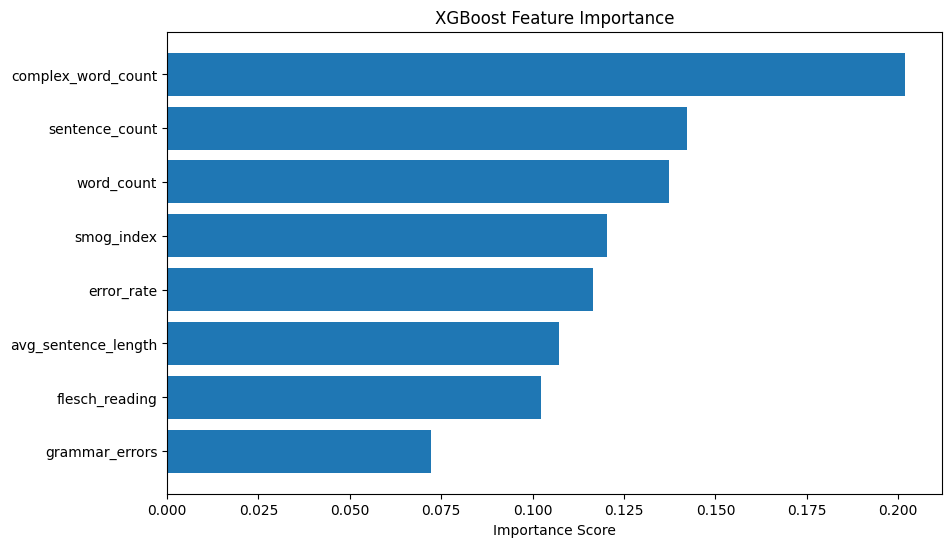

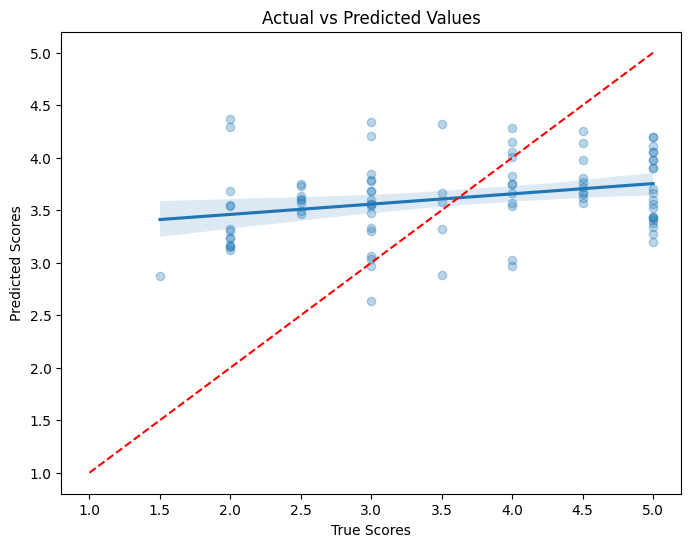

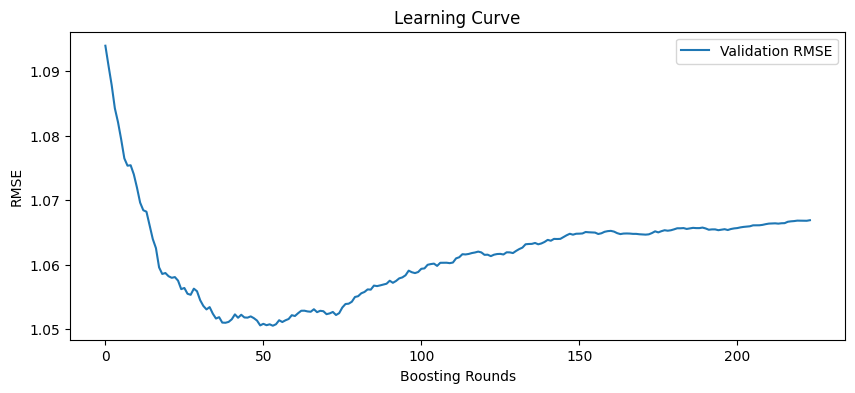

In [ ]:
# Step-7: Model Training and Evaluation
# ---------------------------------------
# Train an XGBoost model to predict grammar scores using the extracted features.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor, callback
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch  # For GPU detection

# Custom learning rate decay with a default for the second parameter
def learning_rate_decay(epoch, num_boost_round=None):
    initial_lr = 0.02
    min_lr = 0.001
    decay_factor = 0.99
    return max(min_lr, initial_lr * (decay_factor ** epoch))

# Configure the XGBoost model with GPU settings and evaluation metrics
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=5,
    subsample=0.75,
    colsample_bytree=0.75,
    gamma=0.2,
    reg_alpha=0.2,
    reg_lambda=0.2,
    random_state=42,
    eval_metric=['rmse', 'mae'],  # Set evaluation metrics in the constructor
    tree_method='gpu_hist' if torch.cuda.is_available() else 'hist',
    predictor='gpu_predictor' if torch.cuda.is_available() else 'cpu_predictor',
    callbacks=[
        callback.LearningRateScheduler(learning_rate_decay),
        callback.EarlyStopping(rounds=150)  # Early stopping callback
    ]
)

# Train the model using the training set and validate on the validation set.
print("Training model...")
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=50
)

# Generate predictions on the validation set
val_pred = model.predict(X_val)
y_min, y_max = y.min(), y.max()
val_pred = np.clip(val_pred, y_min, y_max)

# Calculate and print evaluation metrics
print("\n=== Validation Metrics ===")
print(f"MSE: {mean_squared_error(y_val, val_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, val_pred)):.3f}")
print(f"MAE: {mean_absolute_error(y_val, val_pred):.3f}")
print(f"R²: {r2_score(y_val, val_pred):.3f}")

# Analyze error distribution
error = val_pred - y_val
print("\n=== Error Distribution ===")
print(f"Mean Error: {error.mean():.3f}")
print(f"Std.Dev: {error.std():.3f}")
print(f"Within ±0.5: {(abs(error) <= 0.5).mean():.1%}")

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sorted_idx = model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance Score')
plt.show()

# Plot Actual vs Predicted Values
plt.figure(figsize=(8, 6))
sns.regplot(x=y_val, y=val_pred, scatter_kws={'alpha': 0.3})
plt.plot([y_min, y_max], [y_min, y_max], 'r--')
plt.title('Actual vs Predicted Values')
plt.xlabel('True Scores')
plt.ylabel('Predicted Scores')
plt.show()

# Plot Learning Curve (RMSE over boosting rounds)
results = model.evals_result()
plt.figure(figsize=(10, 4))
plt.plot(results['validation_0']['rmse'], label='Validation RMSE')
plt.title('Learning Curve')
plt.ylabel('RMSE')
plt.xlabel('Boosting Rounds')
plt.legend()
plt.show()

# Save the trained model for future use
model.save_model("grammar_scoring_model.json")


In [ ]:
# Step-8: Generate Predictions and Create Submission
# ---------------------------------------------------
# Use the trained model to predict grammar scores for test data and create the submission file.
import numpy as np
import pandas as pd

# Predict test scores using the trained model
test_pred = model.predict(test_feature_df)

# Clip predictions to ensure they fall within the allowed range [1, 5]
test_pred = np.clip(test_pred, 1, 5)

# Create a submission DataFrame with audio filenames and corresponding grammar scores
submission = pd.DataFrame({
    'audio_filename': test_df['filename'],
    'grammar_score': test_pred.round(2)  # Round predictions to 2 decimal places
})

# Save the submission file as CSV without the index
submission.to_csv('submission.csv', index=False)
print("Submission file created with predictions!")


Submission file created with predictions!
